<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_2/0_Pharmacy_Complete_guided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pharmacy [extracted from the textbook] (guided)

----------------------------------------------------
**OPIM 5641: Business Decision Modeling - University of Connecticut**


## Setup Your Environment/Imports
We may often use the solver 'IPOPT' instead of 'cbc' when tackling nonlinear optimization problems.

In [ ]:
# before you do anything...
# mount your drive!
# click folder on the left...
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        #!apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

     |████████████████████████████████| 9.1 MB 6.0 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 


# Linear Regression

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression) is one of the most important techniques employed in business analytics. In a linear regression problem, we are given a dataset consisting of a list of pairs of elements $(x,z(x))$, where $x$ is some controlable or observable value (e.g., number of years of study) and $z(x)$ is the target value (e.g., expected salary in the future). The goal of linear regression is to come up with a formula that will allow us to guess $z(x)$ given $x$ based on historic data.


When using **linear** regression, we assume that a certain phenomenon can be predicted by a linear expression, i.e.:

$𝑦(𝑥)=𝑎+b𝑥$,

where $x$ is the observable value and $y(x)$ is our estimate the value we want to guess which depends linearly on $x$. In our example, if pairs $(10,50000)$ and $(20,100000)$ belong to our dataset, this formula would probably indicate that, if $x = 15$, the value of $y(x)$ would be 75000.

Linear regression is about finding $a$ and $b$ such that the formula $y(x) = a + bx$ approximates the actual value $z(x)$ as well as possible. In general, though, the formula behind the actual value of $z(x)$ may not be linear, so we should expect our formula to make **errors**. This is OK and is expected.

We can cast the linear regression problem as follows: given a set $X$ of values $(x,z(x))$, our goal is to find $a$ and $b$ such that the sum of the errors is minimized, i.e., we want to find $a$ and $b$ that minimize the **least square error**, which is given by the following expression:

$\sum\limits_{x \in X}(y(x) - z(x))^2$

As we learned from the `Polynomial` example - anything with a nonlinear term (an exponent, a square root, a fraction) cannot be solved with our typical linear programming tools.

## Pharmacy (Extracted from the textbook)

A pharmacy has hired you to create a predictive model for determining, based on the number of hours that the pharmacy is open each week, the revenue.  Data from previous weeks is provided below:

Hours	| Revenue
---|---
	40	|5958
	44	| 6662
	48	| 6004
	48	| 6011
	60	|7250
	70	|8632
	72	|6964
	90	|11097
	100	|9107
	168	|11498

Can you build a model to predict revenue as a function of hours? Note that there are 168 hours in a week, so this is a store that is open 24/7 vs. the traditional 9 AM - 5 PM business hours.

## Data

For problems like this, it is extremely convenient to separate the data from the model. This cuts down on some of the hard-coding.

In [ ]:
# these are the pharmacy hours

X = [
      40,
      44,
     48,
     48,
     60,
     70,
     72,
     90,
     100,
     168
]

# these are the revenue ($) from each corresponding store
Z = [
     5958,
     6662,
     6004,
     6011,
     7250,
     8632,
     6964,
     11097,
     9107,
     11498
]


# Item 1 - linear regression (squared errors) with `scipy` vs. `Pyomo`
Suppose that we assume a linear model, that is,

$
\textrm{Revenue} = a + b \times Hours
$

Create an optimization model to find $a$ and $b$ using least square errors as your error function, i.e., you want to find $a$ and $b$ that minimize the least square error, given by

$\sum\limits_{x \in X}(y(x) - z(x))^2$.


## 1a) Solving with `scipy`

Linear regression is a very traditional problem, so there are libraries and functions in Python to solve the problem. So, before solving the problem using an optimization model, let's see how to solve it using [Scipy](https://www.scipy.org/) (in a single line of code!)

The optimal values for a and b are:
a: 4435.083751    b: 47.070490


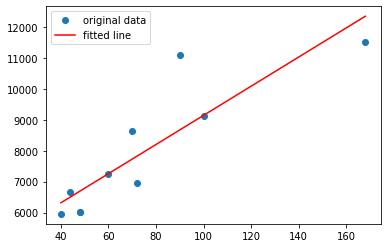

In [ ]:
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for linear regression

# we are going to use scipy, so it will be better to convert our lists into numpy arrays
XX = np.array(X)
ZZ = np.array(Z)

# the values we care about are the first two returned by the function
b, a, r_value, p_value, std_err = stats.linregress(XX, ZZ) # (input data, target variable)
print('The optimal values for a and b are:')
print("a: %f    b: %f" % (a, b))

# first, let's plot the original data
plt.plot(XX, ZZ, 'o', label='original data')
# now, let's plot the line we got; note that we are using the linear regression expression as the second parameter of the plot function
plt.plot(XX, a + b*XX, 'r', label='fitted line')
plt.legend()
plt.show()

### [optional] calculate the `squared_error` by hand

### [optional] use `sklearn` to calculate the `mean_squared error`

In [ ]:
# you can print other values here if you want to inspect

## 1b) Using `Pyomo` to solve the optimization problem

Now you will derive an optimization problem to solve the same problem. You will see that we will get exactly the same results. In the below code, $y$ is the predicted value and $z$ is the (actual) target variable.

**Objective Function**

$\min   \sum\limits_{i \in |X|}(y_i - z_i)^2$ `(objective function)`

We are minimizing the distance between actual and predicted values. Since this function is squared, the order of terms doesn't matter $(y - z)^2$ is the same as $(z-y)^2$

**Write the Constraints**

subject to:
* $y_i = a + b \cdot x_i, \forall i \in |X|$ `(calculate estimates)`

`Domains`
* $a,b \in \mathbb{R}$ `(Parameters of linear regression)`
* $y_i \in \mathbb{R}, i \in [|X|]$ `(estimates for each data point)`



Look how we are making ONE CONSTRAINT per data point! Notice that the linear regression formula is not in the objective function but within the constraints. 

We are trying to find the optimal values of $a$ and $b$ that minimize the squared errors... the distance between actual and predicted values...

### ConcreteModel()

In [ ]:
# declare the model
model = ConcreteModel()

### Declare Decision Variables

In [ ]:
# this is how many observations we have
n_points = len(X)
print(n_points)

10


Note that in nonlinear optimization problems, it is very useful to initialize inital values alongside the domain of your decision variables (in this case, $a$ and $b$.

In [ ]:
# declare decision variables
model.a = Var(domain=Reals,initialize = 1)
model.b = Var(domain=Reals, initialize = 1)
model.y = Var([i for i in range(n_points)],domain=Reals)

In [ ]:
# we can set the initial values for y equal to 0
for i in range(n_points):
  model.y[i] = 0.0

Something to note here is that the domain is `Reals` and NOT `NonNegativeReals`.

We are going to allow our model to make predictions that can overestimate or underestimate.

### Declare Constraints
We are going to have ONE CONSTRAINT per observation in X. 

The `==` operator ensures that the prediction is equal to $a + \hat{X}*b$ where $\hat{X}*b$ is a single observation of X. 

In [ ]:
# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x = X[i]
  model.constraints.add(model.y[i] == model.a + x*model.b)

### Objective Function

In [ ]:
# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += (model.y[i] - Z[i])**2
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

### Pretty Print (check your work)
Let's see what we did.

In [ ]:
# show the model you've created
model.pprint()

2 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    y_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

3 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    y : Size=10, Index=y_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :   0.0 :  None : False : False :  Reals
          1 :  None :   0.0 :  None : False : False :  Reals
          2 :  None :   0.0 :  None : False : False :  Reals
          3 :  None :   0.0 :  None

Things to note:
* Look at how there is one declaration for each of the y (intermediate predictions).
* Look at the objective function and see how $a$, $b$, $X$, $y$ and $Z$ are related. 
  * $X$, $a$ and $b$ are used to calculate $y$, the predicted value of revenue.
  * We are trying the minimize the squared distance between each unique $Z$ (actual revenue) and $y$ (predicted revenue) pair.

### Solve!

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 12
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.038817644119262695
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


This can always be a bit cryptic - but note that the termination condition reads `optimal`.

### Inspect the Results


In [ ]:
# show the results
print("Objective value = ", model.error())
print("A = ", model.a())
print("B = ", model.b())
a = model.a()
b = model.b()

Objective value =  9249747.557586616
A =  4435.083751493429
B =  47.0704898446834


### [optional] make a graph of actual vs. predicted values

In [ ]:
# grab the code from above and see if you can hack it!
# should be the same plot - be careful of your arguments

### [optional] instead of squared error, try mean squared error with `sklearn`.

I'm pretty sure there's not a `squared_error` in `sklearn`, only a `mean_squared_error` where you divide by $n$ to get the average squared error per data point.

Update your objective function, re-run, and check your work with `sklearn`!

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
traindata = pd.DataFrame(X)
traindata # this is a 10 row dataframe corresponding to X

,0
0,40
1,44
2,48
3,48
4,60
5,70
6,72
7,90
8,100
9,168


In [ ]:
trainpreds = 4435.08375149343 + 47.07048984468339*traindata
trainpreds # this is a 10 row dataframe corresponding to the preds!


,0
0,6317.903345
1,6506.185305
2,6694.467264
3,6694.467264
4,7259.313142
5,7730.018041
6,7824.159020
7,8671.427838
8,9142.132736
9,12342.926045


In [ ]:
mean_squared_error(Z, trainpreds) # actual, pred

924974.7557586615

Bam! This is just another way for you to check your work.

## Comparison between 1a and 1b - same!
We get the same exact results! Regression problems are the same things as optimization problems.

# Item 2 - linear regression (absolute errors) with `Pyomo`

The sum of the squared differences is not the only way to measure errors.  Create an optimization model to find $a$ and $b$, but this time minimizing the sum of the absolute differences (https://en.wikipedia.org/wiki/Absolute_value). That is, the objective function now should be as follows:

$\sum\limits_{x \in X}|y(x) - z(x)|$

We will build a second model within this notebook, called `model2` so that we don't mix up our models.



## First attempt...
You can be pretty intuitive here - try to type from memory!

In [ ]:
# declare the model
model2 = ConcreteModel()

n_points = len(X)

# declare decision variables
model2.a = Var(domain=Reals,initialize = 2000)
model2.b = Var(domain=Reals, initialize = 50)
model2.y = Var([i for i in range(n_points)],domain=Reals)

for i in range(n_points):
  model2.y[i] = 0.0

# Constraints
model2.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x = X[i]
  model2.constraints.add(model2.y[i] == model2.a + x*model2.b)

# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += abs(model2.y[i] - Z[i])
model2.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# show the model you've created
model2.pprint()

2 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    y_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

3 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  2000 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :    50 :  None : False : False :  Reals
    y : Size=10, Index=y_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :   0.0 :  None : False : False :  Reals
          1 :  None :   0.0 :  None : False : False :  Reals
          2 :  None :   0.0 :  None : False : False :  Reals
          3 :  None :   0.0 :  None

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model2).write()
# show the results
print("Objective value = ", model2.error())
print("A = ", model2.a())
print("B = ", model2.b())

ValueError: ignored

### Error! 
You can't use `abs()` in the objective function.

**Oops**, we cannot use the function abs() with IPOPT! IPOPT requires functions to be continuous (https://en.wikipedia.org/wiki/Continuous_function) and twice differentiable (https://en.wikipedia.org/wiki/Differentiable_function), and abs() does not satisfy one of these conditions (which one?)

How can we address this issue? Try to think about a way of formulating the abs() function before checking the solution below. Tip: you can use linear expression for that.

### How can we reformulate abs() as a linear constraint?

In addition to every `model.y` which were constraints, you now need a separate `model2.abs_value` constraint - ONE FOR EACH DATA POINT! But we need to be clever about how we overwrite values.

In [ ]:
# Each variable abs[i] will represent |y[i] - z[i]|
model2.abs_value = Var([i for i in range(n_points)],domain=NonNegativeReals)

# The following constrains enforce abs[i] >= |y[i] - z[i]|
# try the values y=14 and z=12 and see how the model would work
# then try the values y=10 and z=12 and see how the model would work
# since it is always [i] we overwrite the constraint if there's not a positive value!
for i in range(n_points):
  model2.constraints.add(model2.abs_value[i] >= model2.y[i] - Z[i])
  model2.constraints.add(model2.abs_value[i] >= -(model2.y[i] - Z[i]))

# Because we want to minimize the sum of absolute values, the solver will pick the smallest possible values of abs[i]. 
# Therefore, we will have abs[i] = |y[i] - z[i]|, as we wanted
obj_expr = 0
for i in range(n_points):
  obj_expr += model2.abs_value[i]
model2.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# check your work
model2.pprint()

    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
3 Set Declarations
    abs_value_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   30 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
    y_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixe

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model2).write()
# show the results
print("Objective value = ", model2.error())
print("A = ", model2.a())
print("B = ", model2.b())
a2 = model2.a()
b2 = model2.b()

### Let's plot both curves

As you can see, they look similar (and equally OK).

In [ ]:
# first, let's plot the original data
plt.plot(XX, ZZ, 'o', label='original data')
# now, let's plot the line we got; note that we are using the linear regression expression as the second parameter of the plot function
plt.plot(XX, a2 + b2*XX, 'r', label='abs. error')
plt.plot(XX, a + b*XX, 'g', label='sq. error')
plt.legend()
plt.show()

### [optional] minimize the `mean_absolute_error`
Simply divide your objective function by n_points and then check your work with `sklearn`.

# Item 3 (a power model with squared error)

Now we are going to see what happens if we replace linear regression for the following expression:

$
\textrm{Revenue} = a \times Hours ^ b
$

First, let's see what happens if we use the expression above and sum of squares as error measure.

**You will probably need to play with a few different initial values before you find a good solution.**

In [ ]:
# declare the model
model3= ConcreteModel()

n_points = len(X)

# declare decision variables
model3.a = Var(domain=Reals,initialize = 1000)
model3.b = Var(domain=Reals, initialize = 1)
model3.y = Var([i for i in range(n_points)],domain=Reals)

# Constraints
model3.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x = X[i]
  model3.constraints.add(model3.y[i] == model3.a * x**(model3.b))

# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += (model3.y[i] - Z[i])**2
model3.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# show the model you've created
model3.pprint()

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model3).write()
# show the results
print("Objective value = ", model3.error())
print("A = ", model3.a())
print("B = ", model3.b())
a3 = model3.a()
b3 = model3.b()

In [ ]:
# first, let's plot the original data
plt.plot(XX, ZZ, 'o', label='original data')
# now, let's plot the line we got; note that we are using the linear regression expression as the second parameter of the plot function
plt.plot(XX, a3*XX**b3, 'b', label='power with sq. error')
plt.plot(XX, a2 + b2*XX, 'r', label='abs. error')
plt.plot(XX, a + b*XX, 'g', label='sq. error')
plt.legend()
plt.show()

# Item 4 (a power model with absolute error)

Now, let's see what happens if we use the exponential expression above and sum of absolute values as error measure.

**You will probably need to play with a few different initial values before you find a good solution.**

In [ ]:
# declare the model
model4 = ConcreteModel()

n_points = len(X)

# declare decision variables
model4.a = Var(domain=Reals,initialize = 1000)
model4.b = Var(domain=Reals, initialize = 1)
model4.y = Var([i for i in range(n_points)],domain=Reals)

# Each variable abs[i] will represent |y[i] - z[i]|
model4.abs_value = Var([i for i in range(n_points)],domain=NonNegativeReals)

# initialize the values of y
for i in range(n_points):
  model4.y[i] = 0.0

# Constraints
model4.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x = X[i]
  model4.constraints.add(model4.y[i] == (model4.a * x**model4.b))


# The following constrains enforce abs[i] >= |y[i] - z[i]|
for i in range(n_points):
  model4.constraints.add(model4.abs_value[i] >= model4.y[i] - Z[i])
  model4.constraints.add(model4.abs_value[i] >= -(model4.y[i] - Z[i]))

# Because we want to minimize the sum of absolute values, the solver will pick the smallest possible values of abs[i]. Therefore, we will have abs[i] = |y[i] - z[i]|, as we wanted
obj_expr = 0
for i in range(n_points):
  obj_expr += model4.abs_value[i]
model4.error = Objective(
                      expr = obj_expr,
                      sense = minimize)


# show the model you've created
model4.pprint()

# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model4).write()
# show the results
print("Objective value = ", model4.error())
print("A = ", model4.a())
print("B = ", model4.b())
a4 = model4.a()
b4 = model4.b()

In [ ]:
# first, let's plot the original data
plt.plot(XX, ZZ, 'o', label='original data')
# now, let's plot the line we got; note that we are using the linear regression expression as the second parameter of the plot function
plt.plot(XX, a4*XX**b4, 'y', label='power with abs. error')
plt.plot(XX, a3*XX**b3, 'b', label='power with sq. error')
#plt.plot(XX, a2 + b2*XX, 'r', label='abs. error')
#plt.plot(XX, a + b*XX, 'g', label='sq. error')
plt.legend()
plt.show()